## Vision and Display System Lab. 영상처리 관련 면접문제

### 1. Sobel mask를 통한 edge 영상을 획득한 후 정제된 edge 출력하기
* 실험과정
    * Sobel mask를 적용하여 얻은 edge 영상 획득
    * 획득한 edge 영상에 대해 Non-maximal suppression을 수행
    * 얇아진 edge 영상에 대해 Hythesis 알고리즘을 적용 후 최종 출력
        - 2단계 thresholding을 조정하며 유의미한 edge 남도록 실험
* 관련 이론 및 적용 알고리즘 설명
    * 해당 문제 해결에 사용한 영상 처리 이론과 알고리즘을 정리
* 실험결과
    * 영상 첨부
    * 결과 영상에 대해 자세히 분석

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [2]:
'''
Edge image를 얻는과정
1. 원본 이미지, 원본 흑백 이미지 가져오기
2. 노이즈를 제거하기 위해 Gaussian Filter를 적용
3. Gaussian Filter적용한 이미지에 Sobel Filter를 적용한다.
4. Sobel Filter적용한 이미지에 Non-Maximal Suppression을 적용한다.
5. Non-Maximal Suppression을 적용한 이미지에 Double Thresholding을 적용한다.
6. Double Threshloding을 적용한 이미지에 Hythesis 알고리즘을 적용한다.
'''
class EdgeDetect_SobelFilter:
    def __init__(self, sigma, Gaussian_filter_size, StrongThreshold, WeakThreshold): 
        self.sobel_filter_x = np.array([
            [1.0, 0.0, -1.0],
            [2.0, 0.0, -2.0],
            [1.0, 0.0, -1.0]
        ]) # x축 방향 Sobel Filter
        self.sobel_filter_y = np.array([
            [1.0, 2.0, 1.0],
            [0.0, 0.0, 0.0],
            [-1.0, -2.0, -1.0]
        ]) # y축 방향 Sobel Filter
        self.sigma = sigma # Gaussian Filter의 sigma 값
        self.StrongThreshold = StrongThreshold # 강 엣지 검출을 위한 임계값
        self.WeakThreshold = WeakThreshold # 약 엣지 검출을 위한 임계값
        self.Gaussian_filter_size = Gaussian_filter_size # Gaussian Filter의 크기


    def ZeroPadding(self, image, padding_factor): # 필터 적용 시 이미지 크기가 작아지는 것을 방지하기 위한 Zero Padding
        padding_image = np.zeros((
            image.shape[0] + 2*padding_factor,
            image.shape[1] + 2*padding_factor
        ), dtype=np.uint8) # Padding한 이미지의 크기를 이미 영행렬로 지정한다.
        
        for row in range(image.shape[0]):
            for col in range(image.shape[1]):
                padding_image[row + padding_factor][col + padding_factor] = image[row][col] # padding된 이미지의 (1, 1)부터 원본 이미지 할당
            
        return padding_image


    def GaussianFilter2D(self): # Gaussian Filter 생성
        GaussianFilter = np.zeros((self.Gaussian_filter_size, self.Gaussian_filter_size)) # 생성할 Gaussian Filter 크기 만큼 영행렬 지정
        m = 0 # Gaussian Filter안 모든 값들을 더해서 나누기 위한 변수
        # Filter의 중앙에 가장 큰 값이 들어 올 수 있도록 한다.
        for row in range(-(self.Gaussian_filter_size // 2), (self.Gaussian_filter_size // 2) + 1):
            for col in range(-(self.Gaussian_filter_size // 2), (self.Gaussian_filter_size // 2) + 1):
                GaussianFilter[row + 1][col + 1] = (1 / (2 * np.pi * self.sigma**2)) * (np.exp(-(row**2 + col**2) / (2 * (self.sigma**2))))
                m += GaussianFilter[row + 1][col + 1]

        return GaussianFilter / m


    def ApplyGaussianFilter(self, image, stride): # Gaussian Filter 적용
        GaussianFilter = self.GaussianFilter2D() # Gaussian Filter 생성

        padding_factor = self.Gaussian_filter_size // 2 # filter 크기에 따른 Padding Factor

        padding_image = self.ZeroPadding(image, padding_factor) # Zero Padding 적용

        conv_height_size = int(((image.shape[0] + (2*padding_factor) - self.Gaussian_filter_size) / stride) + 1)
        conv_width_size = int(((image.shape[1] + (2*padding_factor) - self.Gaussian_filter_size) / stride) + 1)
        # 필터 적용 후 이미지의 놀이와 너비
        # 높이 = ((원본 이미지 높이 + 2*padding_factor) - Gaussian Filter 크기) / stride) + 1
        # 너비 = ((원본 이미지 너비 + 2*padding_factor) - Gaussian Filter 크기) / stride) + 1 
        result_image = np.zeros((
            conv_height_size,
            conv_width_size
        ), dtype=np.uint8) # 필터 적용후 이미지 크기 영행렬로 지정

        for row in range(conv_height_size):
            for col in range(conv_width_size):
                G_img = np.sum(padding_image[
                    row:row + self.Gaussian_filter_size,
                    col:col + self.Gaussian_filter_size
                ] * GaussianFilter) # convolution 연산 진행 (필터 자체가 대칭이기 때문에 y축 반전을 하지 않아도 됨)

                result_image[row, col] = G_img # convolution 연산 값 할당
        
        return result_image


    def ApplySobelFilter(self, image, stride): # Sobel Filter 적용
        padding_factor = self.sobel_filter_x.shape[0] // 2 # filter 크기에 따른 Padding Factor

        conv_height_size = int(((image.shape[0] + (2*padding_factor) - self.sobel_filter_x.shape[0]) / stride) + 1)
        conv_width_size = int(((image.shape[1] + (2*padding_factor) - self.sobel_filter_x.shape[0]) / stride) + 1)
        # 필터 적용 후 이미지의 놀이와 너비
        # 높이 = ((원본 이미지 높이 + 2*padding_factor) - Gaussian Filter 크기) / stride) + 1
        # 너비 = ((원본 이미지 너비 + 2*padding_factor) - Gaussian Filter 크기) / stride) + 1 
        padding_image = self.ZeroPadding(image, padding_factor) # Zero Padding 적용
        
        result_image = np.zeros((
            conv_height_size, 
            conv_width_size 
        ), dtype=np.uint8) # 필터 적용후 이미지 크기 영행렬로 지정

        result_EdgeNormal = np.zeros((
            conv_height_size, 
            conv_width_size 
        )) # Non-Maximal Suppression 적용을 위해 Edge의 방향을 알 수 있는 값을 할당할 행렬 지정

        for row in range(conv_height_size):
            for col in range(conv_width_size):
                img_x = np.sum(padding_image[ 
                    row:row + self.sobel_filter_x.shape[0],
                    col:col + self.sobel_filter_x.shape[0]
                ] * self.sobel_filter_x)
                img_y = np.sum(padding_image[
                    row:row + self.sobel_filter_y.shape[0],
                    col:col + self.sobel_filter_y.shape[0]
                ] * self.sobel_filter_y) # convolution 연산 진행

                EdgeMaginitude = np.sqrt(img_x**2 + img_y**2) # Edge 크기를 구한다.
                EdgeNormal = np.arctan2(img_x, img_y) # Edge의 방향을 알기 위한 값을 구한다.

                if EdgeMaginitude > 255:
                    EdgeMaginitude = 255 # 연산 결과 255보다 크면 255로 고정
                elif EdgeMaginitude < 0:
                    EdgeMaginitude = 0 # 연산 결과 0보다 작으면 0으로 고정
                    
                result_image[row, col] = EdgeMaginitude # Edge 크기 할당
                result_EdgeNormal[row, col] = EdgeNormal # Edge normal값 할당
                
        return result_image, result_EdgeNormal

    
    def NonMaximalSuppresion(self, image, EdgeNormal): 
        result_image = np.zeros((
            image.shape[0],
            image.shape[1]
        ), dtype=np.uint8) # NMS 적용 후 이미지 크기 영행렬로 지정

        EdgeNormal = EdgeNormal * 180 / np.pi # 라디안 값을 각도로 변환

        for row in range(EdgeNormal.shape[0]):
            for col in range(EdgeNormal.shape[1]):
                if EdgeNormal[row][col] < 0:
                    EdgeNormal[row][col] = EdgeNormal[row][col] + 180 # NMS 적용의 편의를 위해 음의 각도 값을 양의 각도 값으로 변환 

        for row in range(1, image.shape[0] - 1):
            for col in range(1, image.shape[1] - 1):
                if (EdgeNormal[row][col] >= 0 and EdgeNormal[row][col] < 22.5) or (EdgeNormal[row][col] >= 157.5 and EdgeNormal[row][col] <= 180):
                    right_pixel = image[row][col + 1] # Edge Normal 값이 0<= Edge Normal < 22.5, 157.5 <= Edge Normal <= 180 이면 q에 값을 할당
                    left_pixel = image[row][col - 1] # Edge Normal 값이 0<= Edge Normal < 22.5, 157.5 <= Edge Normal <= 180 이면 r에 값을 할당
                elif EdgeNormal[row][col] >= 22.5 and EdgeNormal[row][col] < 67.5:
                    right_pixel = image[row - 1][col + 1] # Edge Normal 값이 22.5 <= Edge Normal < 67.5 이면 q에 값을 할당
                    left_pixel = image[row + 1][col - 1] # Edge Normal 값이 22.5 <= Edge Normal < 67.5 이면 r에 값을 할당
                elif EdgeNormal[row][col] >= 67.5 and EdgeNormal[row][col] < 112.5:
                    right_pixel = image[row + 1][col] # Edge Normal 값이 67.5 <= Edge Normal < 112.5 이면 q에 값을 할당
                    left_pixel = image[row - 1][col] # Edge Normal 값이 67.5 <= Edge Normal < 112.5 이면 r에 값을 할당
                elif EdgeNormal[row][col] >= 112.5 and EdgeNormal[row][col] < 157.5:
                    right_pixel = image[row + 1][col + 1] # Edge Normal 값이 112.5 <= Edge Normal < 157.5 이면 q에 값을 할당
                    left_pixel = image[row - 1][col - 1] # Edge Normal 값이 112.5 <= Edge Normal < 157.5 이면 r에 값을 할당

                if image[row][col] >= right_pixel and image[row][col] >= left_pixel: 
                    result_image[row, col] = image[row][col] # 위 조건문에서 할당된 q, r값 보다 같거나 크면 현재 픽셀을 기준 8방향 중 가장 큰 픽셀 값을 가짐
                else:
                    result_image[row, col] = 0 # 아니면 0 -> Edge의 두께가 앏아짐

        return result_image


    def Double_Thresholding(self, image):
        result_image = np.zeros((
            image.shape[0],
            image.shape[1]
        ), dtype=np.uint8) # Double Thresholding 적용 후 이미지 크기 영행렬로 지정

        for row in range(image.shape[0]):
            for col in range(image.shape[1]):
                if image[row][col] >= self.StrongThreshold: # 픽셀 값이 강 엣지 임계값보다 크거나 같으면 255 할당
                    image[row][col] = 255
                    result_image[row, col] = image[row][col]
                elif image[row][col] >= self.WeakThreshold and image[row][col] <= self.StrongThreshold:
                    # 픽셀 값이 약 엣지 임계값보다 작거나 같거나 강 엣지 임계값보다 크거나 같으면 80할당 
                    image[row][col] = 80
                    result_image[row, col] = image[row][col]
                else:
                    image[row][col] = 0 # 약 엣지보다 작은 픽셀 값은 0으로 할당
                    result_image[row, col] = image[row][col]
                    
        return result_image


    def EdgeTracking_Hythesis(self, image):
        for row in range(1, image.shape[0]):
            for col in range(1, image.shape[1]):
                if image[row][col] == 80:
                    if (
                        image[row - 1][col - 1] == 255 or
                        image[row - 1][col] == 255 or
                        image[row - 1][col + 1] == 255 or
                        image[row][col - 1] == 255 or
                        image[row][col + 1] == 255 or
                        image[row + 1][col - 1] == 255 or
                        image[row + 1][col] == 255 or
                        image[row + 1][col + 1] == 255
                    ): # 픽셀 주변 8방향의 이웃된 픽셀 중 강 엣지에 헤당되는 픽셀이 있는지 탐색 => 있으면 강 엣지 값을 준다.
                        image[row][col] = 255
                    else: # 주변 픽셀 중 강 엣지에 해당되는 픽셀이 없음 => 제거
                        image[row, col] = 0

        return image
    

    def Detection_and_ImagePlot(self, image):
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 3, 1)
        plt.title('Original image')
        plt.imshow(image, cmap='gray')
        plt.axis('off') # 원본 이미지 plot

        Gaussian_filtered_image = self.ApplyGaussianFilter(image, 1)
        plt.subplot(2, 3, 2)
        plt.title('Gaussian filtered image')
        plt.imshow(Gaussian_filtered_image, cmap='gray')
        plt.axis('off') # Gaussian Filter 적용 이미지 plot

        filtered_image, EdgeNormal = self.ApplySobelFilter(Gaussian_filtered_image, 1)
        plt.subplot(2, 3, 3)
        plt.title('Sobel filtered image')
        plt.imshow(filtered_image, cmap='gray')
        plt.axis('off') # Soble Filter 적용 이미지 plot

        NMS_image = self.NonMaximalSuppresion(filtered_image, EdgeNormal)
        plt.subplot(2, 3, 4)
        plt.title('Apply NMS to filtered image')
        plt.imshow(NMS_image, cmap='gray')
        plt.axis('off') # NMS 적용 이미지 plot

        DoubleThresholding_image = self.Double_Thresholding(NMS_image)
        plt.subplot(2, 3, 5)
        plt.title('Double Thresholding image')
        plt.imshow(DoubleThresholding_image, cmap='gray')
        plt.axis('off') # Double Thresholding 적용 이미지 plot

        Final_result_image = self.EdgeTracking_Hythesis(DoubleThresholding_image)
        plt.subplot(2, 3, 6)
        plt.title('Final result image')
        plt.imshow(Final_result_image, cmap='gray')
        plt.axis('off') # Hythesis 알고리즘 적용한 이미지 plot
        plt.show()

        return Final_result_image
                    

이미지를 불러왔습니다.
→ 이미지1 shape: (427, 640)
→ 이미지2 shape: (425, 640)


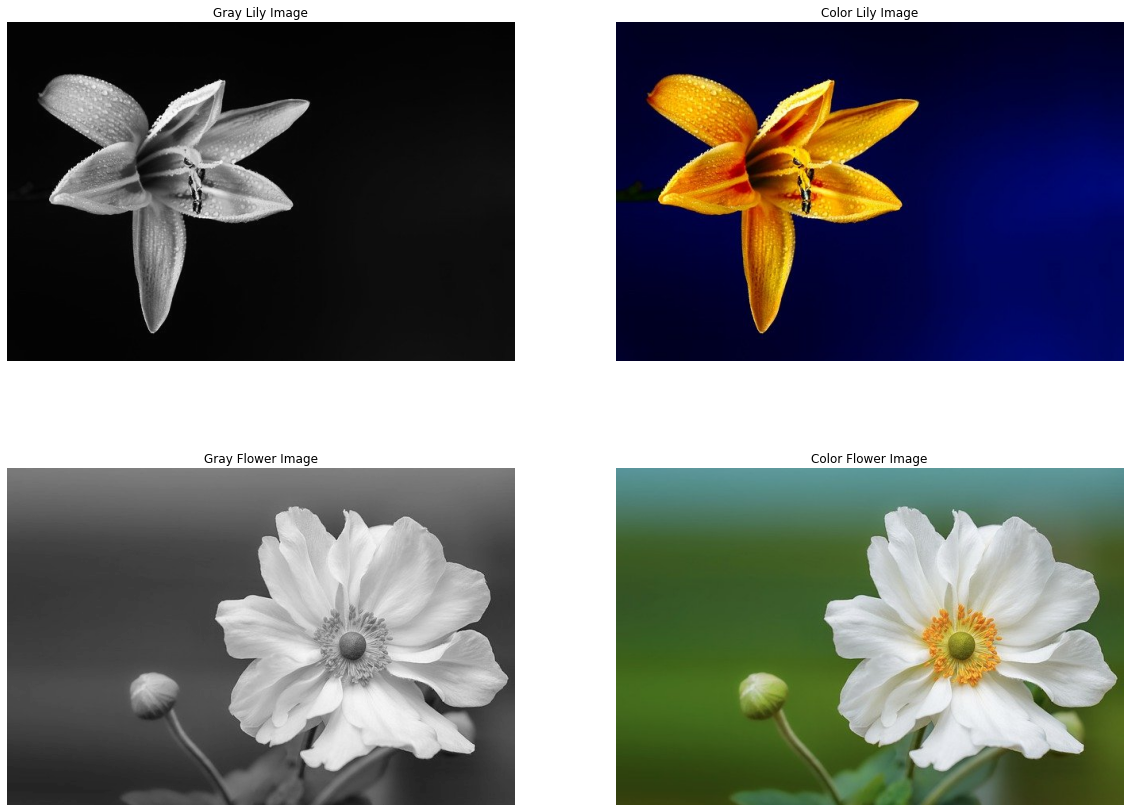

In [3]:
# 이미지 불러오기
try:
    original_gray_image1 = np.array(Image.open('./images/lily.jpg').convert('L')) # 이미지1 (Gray scale)
    original_color_image1 = np.array(Image.open('./images/lily.jpg')) # 이미지1 (Color)
    original_gray_image2 = np.array(Image.open('./images/flower.jpg').convert('L')) # 이미지2 (Gray scale)
    original_color_image2 = np.array(Image.open('./images/flower.jpg')) # 이미지2 (Color)
    print('이미지를 불러왔습니다.')
    print('→ 이미지1 shape:', original_gray_image1.shape)
    print('→ 이미지2 shape:', original_gray_image2.shape)
    plt.figure(figsize=(20, 15))
    plt.subplot(2, 2, 1)
    plt.title('Gray Lily Image')
    plt.imshow(original_gray_image1, cmap='gray')
    plt.axis('off')
    plt.subplot(2, 2, 2)
    plt.title('Color Lily Image')
    plt.imshow(original_color_image1)
    plt.axis('off')
    plt.subplot(2, 2, 3)
    plt.title('Gray Flower Image')
    plt.imshow(original_gray_image2, cmap='gray')
    plt.axis('off')
    plt.subplot(2, 2, 4)
    plt.title('Color Flower Image')
    plt.imshow(original_color_image2)
    plt.axis('off')
    plt.show()
except Exception as err:
    print(str(err))


In [4]:
Edge_detect_image1 = EdgeDetect_SobelFilter(sigma=0.5, Gaussian_filter_size=3, StrongThreshold=200, WeakThreshold=150)

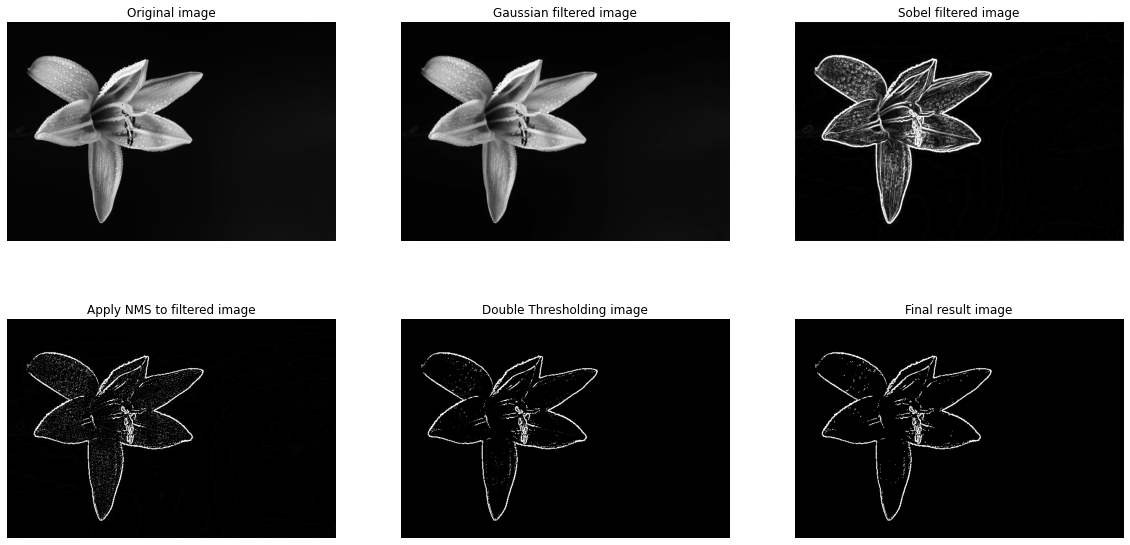

In [5]:
Final_result_image1 = Edge_detect_image1.Detection_and_ImagePlot(original_gray_image1)

In [6]:
Edge_detect_image2 = EdgeDetect_SobelFilter(sigma=0.001, Gaussian_filter_size=3 ,StrongThreshold=180, WeakThreshold=160)

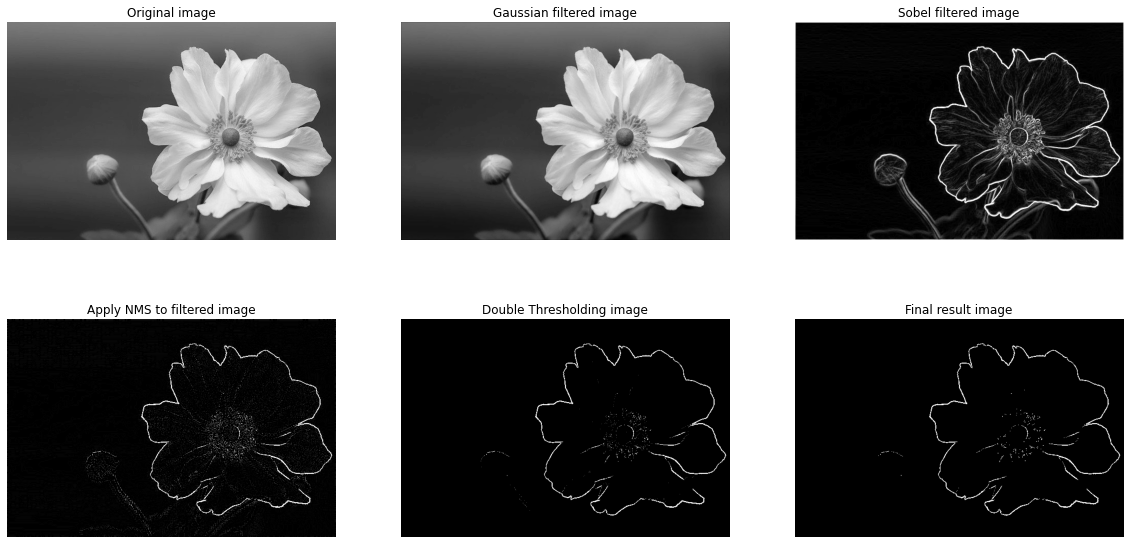

In [7]:
Final_result_image2 = Edge_detect_image1.Detection_and_ImagePlot(original_gray_image2)

### 2. 획득한 Edge 영상에 대해 Boundary tracing를 수행하여 오브젝트 경계 검출

* Moore-Neighbor tracing algorithm을 적용하면 Edge가 끊어지는 순간 Boundary Tracing를 멈춘다.
    * 이를 극복하기위해 Stopping Criterion를 바꿔야함

In [18]:
class BoundaryTracing2:
    def __init__(self, image, edge_image, edge_kernel, fill_kernel):
        self.image = image
        self.edge_image = edge_image
        self.edge_kernel = edge_kernel
        self.fill_kernel = fill_kernel

    
    def fill_image(self, image):
        result_image = np.zeros((
            image.shape[0],
            image.shape[1]
        ))

        for col in range(image.shape[1]):
            for row in reversed(range(image.shape[0])):
                if image[row][col] < 255: 
                    result_image[row][col] = 255 # 아래 위
                else:
                    break

        for row in range(image.shape[0]):
            for col in range(image.shape[1]):
                if image[row][col] < 255: 
                    result_image[row][col] = 255 # 왼 오
                else:
                    break

        for row in range(image.shape[0]):
            for col in reversed(range(image.shape[1])):
                if image[row][col] < 255: 
                    result_image[row][col] = 255 # 오 왼
                else:
                    break

        for col in reversed(range(image.shape[1])):
            for row in range(image.shape[0]):
                if image[row][col] < 255: 
                    result_image[row][col] = 255 # 위 아래
                else:
                    break
                
      
        for row in range(image.shape[0]):
            for col in range(image.shape[1]):
                if result_image[row][col] == 0:
                    result_image[row, col] = 255
                else:
                    result_image[row, col] = 0

        return result_image


    def Morphology_closing(self):
        kernel1 = np.ones((self.edge_kernel[0], self.edge_kernel[1]))
        kernel2 = np.ones((self.fill_kernel[0], self.fill_kernel[1]))

        edge_fill_image = cv2.morphologyEx(self.edge_image, cv2.MORPH_CLOSE, kernel=kernel1)
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(edge_fill_image, cmap='gray')
        plt.axis('off')

        filled_image = self.fill_image(edge_fill_image)
        plt.subplot(1, 3, 2)
        plt.imshow(filled_image, cmap='gray')
        plt.axis('off')

        closeing_image = cv2.morphologyEx(filled_image, cv2.MORPH_CLOSE, kernel=kernel2)
        plt.subplot(1, 3, 3)
        plt.imshow(closeing_image, cmap='gray')
        plt.axis('off')
        plt.show()

        return closeing_image


    def moore_neighbor_algorithm(self):
        B=[]
        starting_pixel = []
        closeing_image = self.Morphology_closing()

        for row in range(closeing_image.shape[0]):
            for col in range(closeing_image.shape[1]):
                if closeing_image[row][col] == 255:
                    starting_pixel.append((row, col))
        
        B_x = starting_pixel[0][0]
        B_y = starting_pixel[0][1]
        B.append(starting_pixel[0])

        b_x = starting_pixel[0][0]
        b_y = starting_pixel[0][1]-1

        d_x = b_x - B_x
        d_y = b_y - B_y

        offsetTable = [(0,0),(0,-1),(-1,-1),(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1)]
        count = 1
        result_image = np.zeros((
                    self.image.shape[0],
                    self.image.shape[1],
                    self.image.shape[2]
                ), dtype=np.uint8)
        while(count<=2):
            id=0
            for i in range(9):
                if(d_x == offsetTable[i][0] and d_y == offsetTable[i][1]):
                    id = i            
                    break
            
            while(True):
                if(id == 8):
                    id = 0       
                c_x=B_x+offsetTable[id+1][0]
                c_y=B_y+offsetTable[id+1][1]        
                if (closeing_image[c_x][c_y]!=0):
                    B_x = c_x
                    B_y = c_y                       
                    temp = (B_x,B_y)           
                    if (temp in B)==True:
                        count += 1
                    B.append((B_x,B_y))
                    d_x = prev_x-B_x
                    d_y = prev_y-B_y
                    break
                prev_x = c_x
                prev_y = c_y        
                id += 1

        for row in range(result_image.shape[0]):
            for col in range(result_image.shape[1]):
                for channel in range(result_image.shape[2]):
                    result_image[row, col, channel] = self.image[row][col][channel] # 원본 이미지를 결과 이미지 영행렬에 할당

        for index in B: # Edge 위치 정보를 뽑아서 Green 채널에만 255값을 할당해 물체의 경계가 초록색으로 강조되도록 할당
            result_image[index[0], index[1], 0] = 0
            result_image[index[0]-1, index[1]-1, 1] = 255
            result_image[index[0], index[1], 1] = 255
            result_image[index[0]+1, index[1]+1, 1] = 255
            result_image[index[0], index[1], 2] = 0
        
        return result_image

In [19]:
boundary1 = BoundaryTracing2(original_color_image1, Final_result_image1, [15, 15], [3, 3])

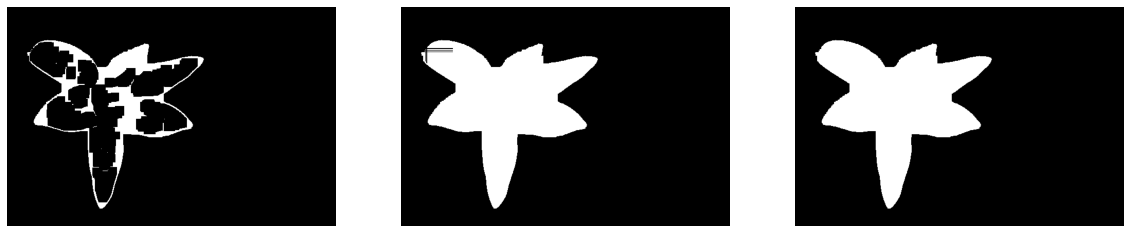

In [20]:
K = boundary1.Morphology_closing()

In [10]:
result_boundary_image1 = boundary1.moore_neighbor_algorithm()

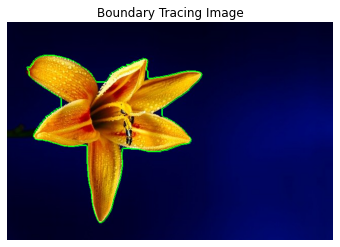

In [11]:
plt.title('Boundary Tracing Image')
plt.imshow(result_boundary_image1)
plt.axis('off')
plt.show()

In [12]:
boundary2 = BoundaryTracing2(original_color_image2, Final_result_image2, [30, 10], [3, 3])

In [13]:
result_boundary_image2 = boundary2.moore_neighbor_algorithm()

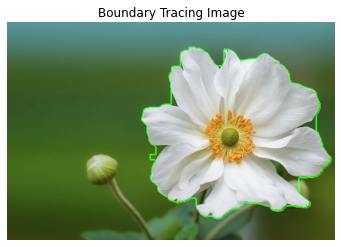

In [14]:
plt.title('Boundary Tracing Image')
plt.imshow(result_boundary_image2)
plt.axis('off')
plt.show()